In [12]:
import numpy as np
import warnings

In [121]:
import pandas as pd

In [130]:
import seaborn as sns

In [139]:
import scipy as sp

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [9]:
import text_classification_params_checker_custom
checker = text_classification_params_checker_custom.Checker()

In [73]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [14]:
warnings.filterwarnings('ignore', category=FutureWarning)

### Проверка чекера

In [10]:
init_params = {
    "count_vectorizer_params": 
    {
        "min_df": 5,
        "ngram_range": [1, 2]
    }, 
    "tfidf_transformer_params": {
        "norm": "l1"    
    }, 
    "logistic_regression_params": {
        "C": 1
    }
}

In [15]:
# ('ivanov@gmail.com', 0.7803444566820602)
warnings
checker.check(init_params)

0.7803444566820602

# HyperOpt выбор гиперпараметров

### Целевая функция

In [97]:
def score(params):
    lr_param = params["lr_param"]
    new_params = {
        "count_vectorizer_params": 
        {
            "min_df": int(params['min_df']),
            "max_df": params['max_df'],
            "ngram_range": (1, params['ngram_range']),
            "lowercase": params['lowercase'],
            "binary": params['binary'],
            "max_features": params['max_features'],
        }, 
        "tfidf_transformer_params": {
            "norm": params['norm'],
            "use_idf": params['use_idf'],
        }, 
        "logistic_regression_params": {
            "C": params['C'],
            "n_jobs": 4,
            "random_state": 17,
            "solver": lr_param[0],
            "multi_class": lr_param[1],
            "penalty": lr_param[2]
        }
    }
    return - checker.check(new_params)

## 1 итерация 

In [98]:
warnings.filterwarnings('ignore', category=UserWarning)

In [99]:
space = {
    "min_df": hp.uniformint("min_df", 1, 15),
    "max_df": hp.uniform("max_df", 0.6, 1.0),
    "ngram_range": hp.uniformint("ngram_range", 1, 5),
    "lowercase": hp.choice("lowercase", [False, True]),
    "binary": hp.choice("binary", [False, True]),
    "max_features": hp.uniformint("max_features", 1000, 1000000),
    
    "norm": hp.choice("norm", ["l1", "l2"]),
    "use_idf": hp.choice("use_idf", [False, True]),
    
    "C": hp.loguniform("C", -16, 16),
    "lr_param": hp.choice("lr_param", [
        ('lbfgs', 'multinomial', 'l2'),
        ('lbfgs', 'ovr', 'l2'),
        ('liblinear', 'ovr', 'l1')
    ])
}
trials = Trials()
best = fmin(fn=score, space=space, algo=tpe.suggest, max_evals=300, trials=trials)

100%|██████████| 300/300 [40:33<00:00,  8.11s/it, best loss: -0.8632804463736686]  


### Лучший результат

In [101]:
space_eval(space, best)

{'C': 1683.1632392855847,
 'binary': True,
 'lowercase': True,
 'lr_param': ('lbfgs', 'ovr', 'l2'),
 'max_df': 0.8289692254477152,
 'max_features': 523079,
 'min_df': 3,
 'ngram_range': 1,
 'norm': 'l1',
 'use_idf': True}

In [102]:
score(space_eval(space, best))

-0.8632804463736686

### Собираем результаты

In [120]:
params_list = []
for trial in trials:
    params = {k: v[0] for k,v in trial['misc']['vals'].items()}
    params.update(trial['result'])
    params_list.append(params)

In [123]:
df_results = pd.DataFrame.from_dict(params_list)

In [125]:
df_results.sort_values('loss')

,C,binary,lowercase,lr_param,max_df,max_features,min_df,ngram_range,norm,use_idf,loss,status
289,1683.163239,1,1,1,0.828969,523079.0,3.0,1.0,0,1,-0.863280,ok
299,3244.093278,1,1,1,0.913434,321270.0,2.0,1.0,0,1,-0.863030,ok
264,805.275579,1,1,1,0.905000,603789.0,3.0,1.0,0,1,-0.861773,ok
262,3986.041467,1,1,1,0.916471,611907.0,3.0,1.0,0,1,-0.861521,ok
272,826.183442,1,1,1,0.890334,584426.0,3.0,1.0,0,1,-0.861270,ok
...,...,...,...,...,...,...,...,...,...,...,...,...
19,0.004052,1,0,2,0.702824,762690.0,3.0,2.0,0,0,-0.251068,ok
204,0.000139,0,0,1,0.840172,804425.0,1.0,1.0,1,1,-0.251068,ok
40,0.000001,1,1,2,0.971889,692189.0,7.0,2.0,1,1,-0.248806,ok
5,0.000097,0,0,2,0.952758,423614.0,2.0,4.0,1,1,-0.248806,ok


In [172]:
# df_results.sort_values('loss').to_csv('results.csv')

### Анализ

#### binary

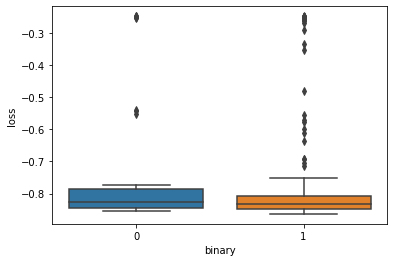

In [145]:
sns.boxplot(x='binary', y='loss', data=df_results)

In [146]:
sp.stats.mannwhitneyu(df_results.query("binary == True")['loss'], df_results.query("binary == False")['loss'])

MannwhitneyuResult(statistic=5312.5, pvalue=0.047112194316375026)

In [148]:
df_results.groupby("binary")['loss'].median()

binary
0   -0.826965
1   -0.831111
Name: loss, dtype: float64

#### lowercase

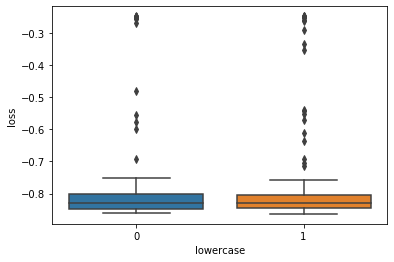

In [149]:
sns.boxplot(x='lowercase', y='loss', data=df_results)

In [150]:
sp.stats.mannwhitneyu(df_results.query("lowercase == True")['loss'], df_results.query("lowercase == False")['loss'])

MannwhitneyuResult(statistic=11004.0, pvalue=0.4554245898394446)

In [151]:
df_results.groupby("lowercase")['loss'].median()

lowercase
0   -0.830231
1   -0.830482
Name: loss, dtype: float64

#### lr_param

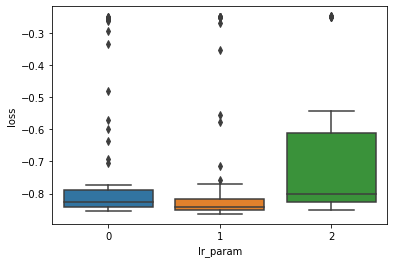

In [152]:
sns.boxplot(x='lr_param', y='loss', data=df_results)

In [153]:
s1 = df_results.query("lr_param == 0")['loss']
s2 = df_results.query("lr_param == 1")['loss']
s3 = df_results.query("lr_param == 2")['loss']
sp.stats.kruskal(s1, s2, s3)

KruskalResult(statistic=37.368779962326904, pvalue=7.681968702514479e-09)

In [154]:
df_results.groupby("lr_param")['loss'].median()

lr_param
0   -0.826462
1   -0.840158
2   -0.800699
Name: loss, dtype: float64

#### max_df

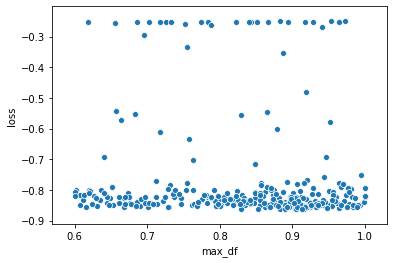

In [160]:
sns.scatterplot(x='max_df', y='loss', data=df_results)

In [161]:
sp.stats.spearmanr(df_results['max_df'], df_results['loss'])

SpearmanrResult(correlation=-0.14212413176913505, pvalue=0.013743237842438505)

#### min_df

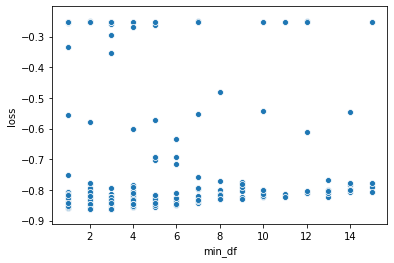

In [162]:
sns.scatterplot(x='min_df', y='loss', data=df_results)

In [163]:
sp.stats.spearmanr(df_results['min_df'], df_results['loss'])

SpearmanrResult(correlation=0.393859346380362, pvalue=1.4243980639218358e-12)

#### max_features

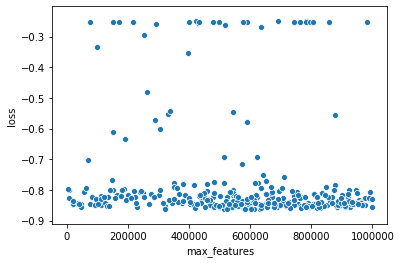

In [158]:
sns.scatterplot(x='max_features', y='loss', data=df_results)

In [159]:
sp.stats.spearmanr(df_results['max_features'], df_results['loss'])

SpearmanrResult(correlation=-0.1765465510122894, pvalue=0.0021459381190966588)

#### ngram_range

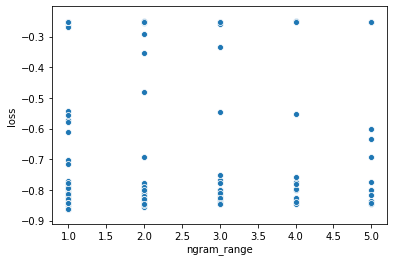

In [164]:
sns.scatterplot(x='ngram_range', y='loss', data=df_results)

In [165]:
sp.stats.spearmanr(df_results['ngram_range'], df_results['loss'])

SpearmanrResult(correlation=0.2945370645014085, pvalue=2.036787782908319e-07)

#### C

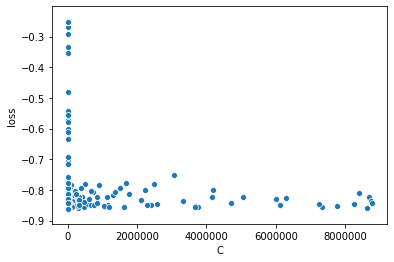

In [176]:
sns.scatterplot(x='C', y='loss', data=df_results)

In [177]:
sp.stats.spearmanr(df_results['C'], df_results['loss'])

SpearmanrResult(correlation=-0.4549953308681493, pvalue=9.796990105233565e-17)

#### norm

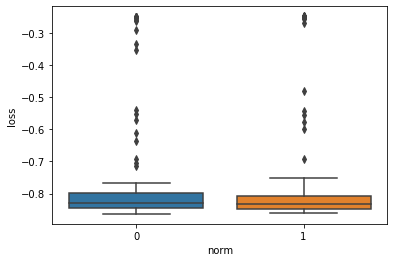

In [169]:
sns.boxplot(x='norm', y='loss', data=df_results)

In [170]:
sp.stats.mannwhitneyu(df_results.query("norm == True")['loss'], df_results.query("norm == False")['loss'])

MannwhitneyuResult(statistic=10696.0, pvalue=0.2844432669044802)

In [171]:
df_results.groupby("norm")['loss'].median()

norm
0   -0.829728
1   -0.831740
Name: loss, dtype: float64

#### use_idf

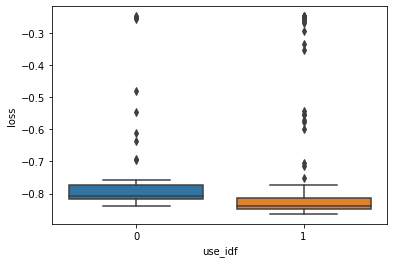

In [166]:
sns.boxplot(x='use_idf', y='loss', data=df_results)

In [167]:
sp.stats.mannwhitneyu(df_results.query("use_idf == True")['loss'], df_results.query("use_idf == False")['loss'])

MannwhitneyuResult(statistic=2636.0, pvalue=2.3615140546661605e-11)

In [168]:
df_results.groupby("use_idf")['loss'].median()

use_idf
0   -0.806478
1   -0.839153
Name: loss, dtype: float64

## 2 итерация

In [178]:
space = {
    "min_df": hp.uniformint("min_df", 1, 5),
    "max_df": hp.uniform("max_df", 0.7, 1.0),
    "ngram_range": hp.uniformint("ngram_range", 1, 3),
    "lowercase": True,
    "binary": True,
    "max_features": hp.uniformint("max_features", 10000, 1000000),
    
    "norm": "l1",
    "use_idf": True,
    
    "C": hp.loguniform("C", -16, 16),
    "lr_param": ('lbfgs', 'ovr', 'l2')
}
trials = Trials()
best = fmin(fn=score, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [12:26<00:00,  7.47s/it, best loss: -0.8708205984459365]


In [180]:
space_eval(space, best)

{'C': 3469.6334697379507,
 'binary': True,
 'lowercase': True,
 'lr_param': ('lbfgs', 'ovr', 'l2'),
 'max_df': 0.8804125006523876,
 'max_features': 246472,
 'min_df': 1,
 'ngram_range': 1,
 'norm': 'l1',
 'use_idf': True}

In [181]:
score(space_eval(space, best))

-0.8708205984459365

In [187]:
space_eval(space, best)

{'C': 3469.6334697379507,
 'binary': True,
 'lowercase': True,
 'lr_param': ('lbfgs', 'ovr', 'l2'),
 'max_df': 0.8804125006523876,
 'max_features': 246472,
 'min_df': 1,
 'ngram_range': 1,
 'norm': 'l1',
 'use_idf': True}

In [197]:
def convert(params):
    lr_param = params["lr_param"]
    new_params = {
        "count_vectorizer_params": 
        {
            "min_df": int(params['min_df']),
            "max_df": params['max_df'],
            "ngram_range": (1, params['ngram_range']),
            "lowercase": params['lowercase'],
            "binary": params['binary'],
            "max_features": params['max_features'],
        }, 
        "tfidf_transformer_params": {
            "norm": params['norm'],
            "use_idf": params['use_idf'],
        }, 
        "logistic_regression_params": {
            "C": params['C'],
            "n_jobs": 4,
            "random_state": 17,
            "solver": lr_param[0],
            "multi_class": lr_param[1],
            "penalty": lr_param[2]
        }
    }
    return new_params

In [198]:
res = convert(space_eval(space, best))
res["author_email"] = "naidenov.aleksei@yandex.ru"

In [199]:
import json

with open("text_classification_params_naidenov.json", "w") as f:
    f.write(json.dumps(res).replace("'", '"'))